# Convolutional Neural Network (CNN): MNIST

In [2]:
import struct

import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow.keras.backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping

In [3]:
def read_images(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic_number, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read the image data
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def read_labels(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic_number, num_labels = struct.unpack(">II", f.read(8))
        # Read the label data
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
    return labels

# load MNIST dataset
root = '../../Datasets/MNIST/'
train_images_path = root + 'train-images-idx3-ubyte/train-images-idx3-ubyte'
train_labels_path = root + 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_path = root + 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_path = root + 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

# read the datasets
train_X = read_images(train_images_path) #images
train_y = read_labels(train_labels_path) #labels
test_X = read_images(test_images_path)   #images
test_y = read_labels(test_labels_path)   #labels

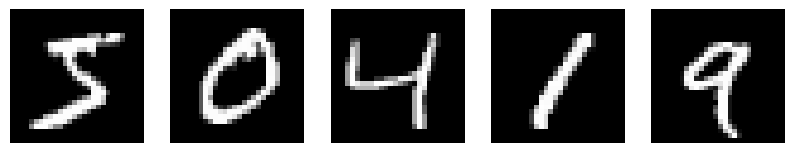

60000

10

In [4]:
# plot sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))  
for i in range(5):
    axes[i].imshow(train_X[i].reshape(28, 28), cmap="gray")  # Reshape the 28x28 image and display it
    axes[i].axis('off')  # Hide the axes
plt.show()

# get some high-level stats
num_images, height, width = train_X.shape
num_classes = len(np.unique(train_y))
display(num_images, num_classes)

In [5]:
# copy train_X and test_X to make them writable
train_X = np.copy(train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32'))
test_X = np.copy(test_X.reshape(test_X.shape[0], 28, 28, 1).astype('float32'))

# normalisation
train_X /= 255.0
test_X /= 255.0

# one-hot encode labels
train_y = np.eye(10)[train_y]
test_y = np.eye(10)[test_y]

In [6]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,      # randomly rotate images up to 10 degrees
    zoom_range=0.1,         # randomly zoom image up to 10% 
    width_shift_range=0.1,  # randomly shift images horizontally up to 10%
    height_shift_range=0.1, # randomly shift images vertically up to 10%
    horizontal_flip=False,  # randomly flip images horizontally
    vertical_flip=False     # randomly flip images vertically
)
datagen.fit(train_X)

In [7]:
# build model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

In [12]:
# compile model
model.compile(
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

In [103]:
# fit model
history = model.fit(
    datagen.flow(train_X, train_y, batch_size=64), 
    validation_data=(test_X, test_y), 
    epochs=10
) 

Epoch 1/10
938/938 [==============================] - 155s 164ms/step - loss: 0.2995 - accuracy: 0.9116 - val_loss: 0.0480 - val_accuracy: 0.9835
Epoch 2/10
938/938 [==============================] - 176s 188ms/step - loss: 0.1113 - accuracy: 0.9663 - val_loss: 0.0374 - val_accuracy: 0.9870
Epoch 3/10
938/938 [==============================] - 159s 169ms/step - loss: 0.0876 - accuracy: 0.9733 - val_loss: 0.1531 - val_accuracy: 0.9573
Epoch 4/10
938/938 [==============================] - 151s 161ms/step - loss: 0.0772 - accuracy: 0.9770 - val_loss: 0.0358 - val_accuracy: 0.9889
Epoch 5/10
938/938 [==============================] - 180s 192ms/step - loss: 0.0682 - accuracy: 0.9807 - val_loss: 0.0265 - val_accuracy: 0.9913
Epoch 6/10
938/938 [==============================] - 166s 177ms/step - loss: 0.0650 - accuracy: 0.9804 - val_loss: 0.0251 - val_accuracy: 0.9923
Epoch 7/10
938/938 [==============================] - 191s 203ms/step - loss: 0.0619 - accuracy: 0.9821 - val_loss: 0.0388 -

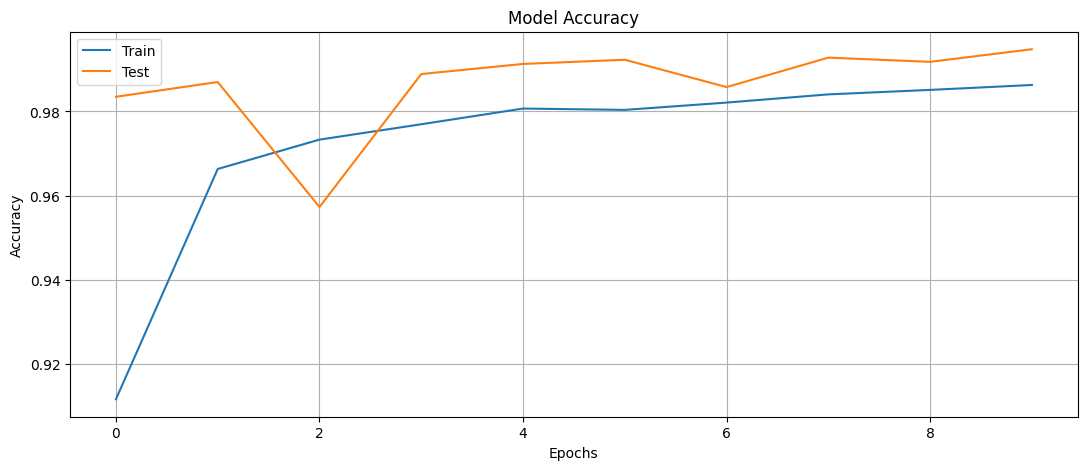

In [104]:
# evaluate model
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

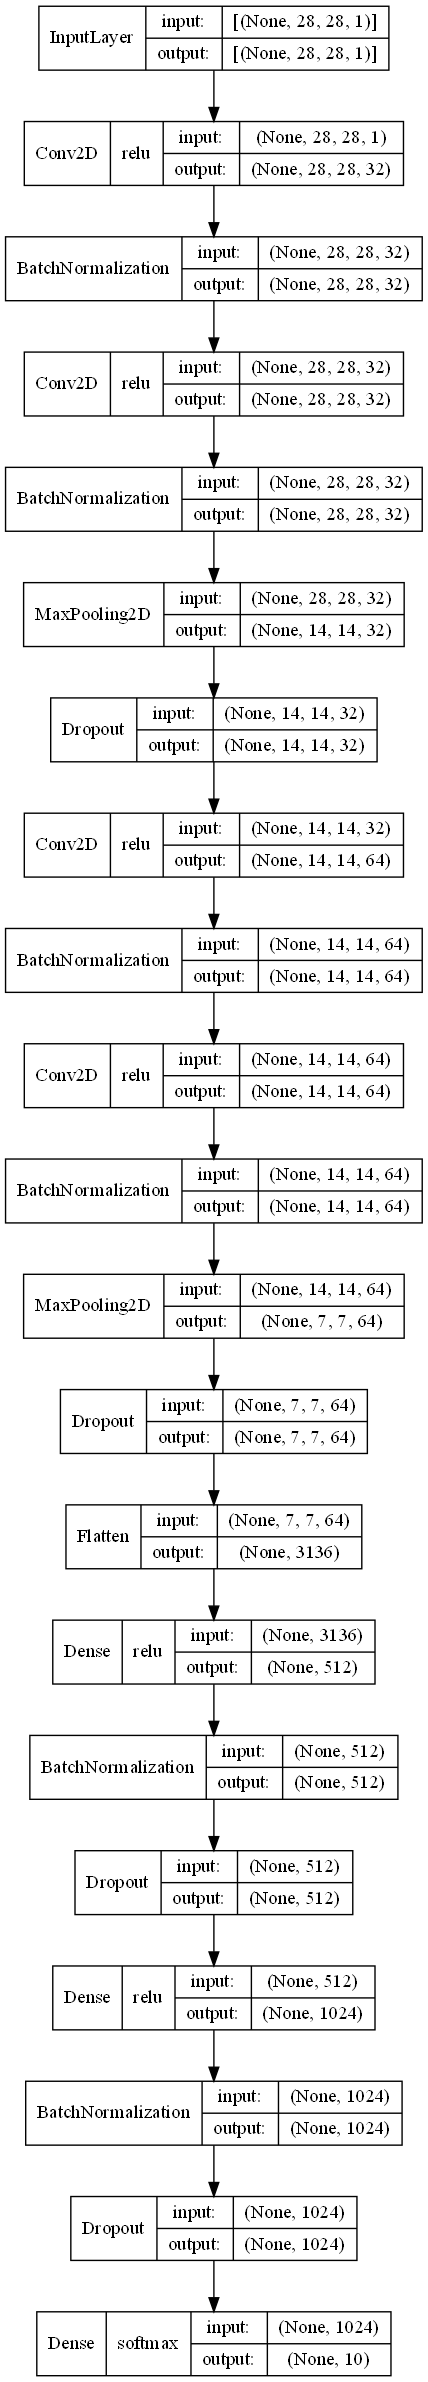

In [9]:
keras.utils.plot_model(
    model,
    to_file="nn-cnn-mnist-model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=True,
    show_trainable=False
)